In [1]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/workspaces/LLM-agent-with-Gemini/fleet-anagram-244304-7dafcc771b2f.json"

_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
_set_if_undefined("TAVILY_API_KEY")
_set_if_undefined("GEMINI_API_KEY")
_set_if_undefined("GOOGLE_API_KEY")

# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

In [2]:
from langchain_core.messages import (
    BaseMessage,
    ToolMessage,
    HumanMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [3]:
from langchain_core.tools import tool
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."]
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [4]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_openai import ChatOpenAI
from langchain_google_vertexai import ChatVertexAI
from typing_extensions import TypedDict


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [5]:
from openai import OpenAI
import os

client = OpenAI(
    api_key = os.getenv('OPENAI_API_KEY')
)
    
models = client.models.list()

print(models)

SyncPage[Model](data=[Model(id='dall-e-3', created=1698785189, object='model', owned_by='system'), Model(id='gpt-4-1106-preview', created=1698957206, object='model', owned_by='system'), Model(id='whisper-1', created=1677532384, object='model', owned_by='openai-internal'), Model(id='gpt-4o-2024-05-13', created=1715368132, object='model', owned_by='system'), Model(id='babbage-002', created=1692634615, object='model', owned_by='system'), Model(id='dall-e-2', created=1698798177, object='model', owned_by='system'), Model(id='gpt-3.5-turbo-16k', created=1683758102, object='model', owned_by='openai-internal'), Model(id='tts-1-hd-1106', created=1699053533, object='model', owned_by='system'), Model(id='tts-1-hd', created=1699046015, object='model', owned_by='system'), Model(id='gpt-3.5-turbo-instruct-0914', created=1694122472, object='model', owned_by='system'), Model(id='gpt-3.5-turbo-instruct', created=1692901427, object='model', owned_by='system'), Model(id='text-embedding-3-small', created=

In [12]:
import functools
from langchain_core.messages import AIMessage
from langchain_mistralai.chat_models import ChatMistralAI


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


llm = ChatOpenAI(model="gpt-4o")
# llm = ChatVertexAI()

# llm = ChatMistralAI(api_key="INaaREFWHmIvmylzZJADnLjNNNEMQwne")

# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart_generator to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# chart_generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

In [13]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

In [14]:
# Either agent can decide to end
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

In [15]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.set_entry_point("Researcher")
graph = workflow.compile()

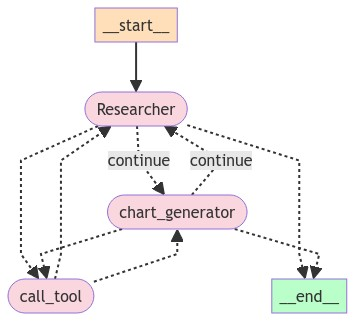

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4SiyH3QWTGtvk1LCCPM0ZGVM', 'function': {'arguments': '{"query":"Singapore temperature data for the past month"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 218, 'total_tokens': 242}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_319be4768e', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-6e0bb832-ffa3-41bc-805b-33f48441e8d1-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Singapore temperature data for the past month'}, 'id': 'call_4SiyH3QWTGtvk1LCCPM0ZGVM'}])], 'sender': 'Researcher'}}
----
{'call_tool': {'messages': [ToolMessage(content='[{"url": "http://www.weather.gov.sg/climate-historical-daily/", "content": "Highest 60-min Rainfall (mm) Highest 120-min Rainfall (mm) Mean Temperature (\\u00b0C) Maximum Temperature (\\u00b0C) Minimu

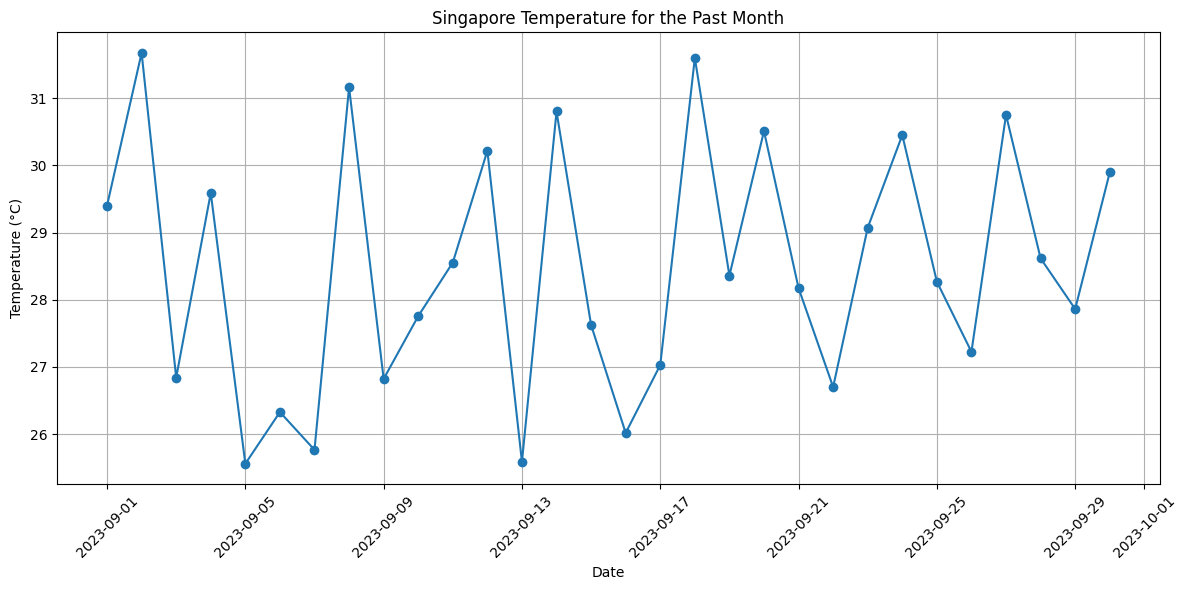

{'call_tool': {'messages': [ToolMessage(content="Successfully executed:\n```python\nimport matplotlib.pyplot as plt\nimport pandas as pd\nimport numpy as np\n\n# Example data for the past month (replace this with actual data)\ndata = {\n    'Date': pd.date_range(start='2023-09-01', end='2023-09-30', freq='D'),\n    'Temperature': np.random.uniform(low=25, high=32, size=30)  # example temperatures\n}\n\ndf = pd.DataFrame(data)\n\n# Plotting\nplt.figure(figsize=(12, 6))\nplt.plot(df['Date'], df['Temperature'], marker='o')\nplt.title('Singapore Temperature for the Past Month')\nplt.xlabel('Date')\nplt.ylabel('Temperature (°C)')\nplt.grid(True)\nplt.xticks(rotation=45)\nplt.tight_layout()\nplt.show()\n\n```\nStdout: \n\nIf you have completed all tasks, respond with FINAL ANSWER.", name='python_repl', tool_call_id='call_gjF7ThTtOe7HrYDI60VYR6Ru')]}}
----
{'chart_generator': {'messages': [AIMessage(content='Here is an example of what the temperature data plot might look like for Singapore ov

In [24]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Singapore's temperature for the past month"
                " then draw a line graph of the data."
                " Once you code it up and output the chart, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")